In [1]:
from spectrum_occupancy import SpectrumOccupancyEstimator

est = SpectrumOccupancyEstimator(fc_hz=98e6, dt_acq_s=0.01, snapshot_dt_s=1.0, nperseg=8192)

out = est.run_from_folder(
    folder=r"data",
    indices=list(range(100)),
    R=20,
    quiet_frac=0.25,
    fit_kernel=True,
    occ_method="per_bin_prob",    
    pi0=0.95,
    p_fa_bin=1e-3,
    p_fa_band=1e-3,
    snf_global=None,               # if you have a calibrated snf, pass it here
    snf_mode="posterior_unoccupied",# stronger: estimates snf from bins with low π_i
    pi_N=0.1,
    band_bw_hz=200e3,
    n_ci_samples=0,                # set e.g. 200 for credible intervals (slower)
)

# Emitters (snapshot 0)
out["per_snapshot"][0]["emitters"]

# Expected occupied bandwidth (soft)
out["per_snapshot"][0]["expected_Bocc_hz"]

# Band-level occupancy (200 kHz)
band = out["per_snapshot"][0]["band"]
band["centers_hz"][:5], band["pi_B"][:5]


(array([88100000., 88300000., 88500000., 88700000., 88900000.]),
 array([0., 0., 0., 0., 1.]))

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def _db(x):
    return 10*np.log10(np.maximum(x, 1e-30))

def plot_snapshot_psd(out, t=0, f_xlim=(88,108), show_uncertainty=True):
    psd_data = out["psd_data"]
    noise = out["noise"]
    snap = out["per_snapshot"][t]

    f = psd_data.f_hz / 1e6
    Y = psd_data.psd
    if Y.ndim == 1:
        y_raw = Y
    else:
        y_raw = Y[t]

    floor = noise.noise_floor[t]
    mu_s_excess = snap["mu_s"]
    mu_total = mu_s_excess + floor

    plt.figure(figsize=(11,4))
    plt.plot(f, _db(y_raw), label="raw Welch PSD", alpha=0.6)
    plt.plot(f, _db(mu_total), label="posterior mean PSD (floor + excess)")
    plt.axhline(_db(floor), linestyle="--", alpha=0.7, label="estimated noise floor")

    if show_uncertainty:
        # pointwise uncertainty from diag(Σ_s) (excess domain)
        sigma_diag = snap["sigma_s_diag"]
        z = 1.96
        lo = np.maximum(mu_total - z*np.sqrt(np.maximum(sigma_diag,0.0)), 1e-30)
        hi = np.maximum(mu_total + z*np.sqrt(np.maximum(sigma_diag,0.0)), 1e-30)
        plt.fill_between(f, _db(lo), _db(hi), alpha=0.2, label="~95% pointwise band")

    plt.xlim(*f_xlim)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("PSD (dB/Hz, relative)")
    plt.title(f"Snapshot {t}: raw PSD vs estimated PSD")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_band_occupancy(out, t=0, f_xlim=(88,108), p_lines=(0.5,0.9,0.95)):
    snap = out["per_snapshot"][t]
    band = snap["band"]

    centers = band["centers_hz"]/1e6
    p_occ = band["pi_B"]
    muB = band["muB"]
    stdB = band["stdB"]
    tauB = band["tauB"]
    bw_mhz = band["band_bw_hz"]/1e6

    # Occupancy probability
    plt.figure(figsize=(11,3))
    plt.plot(centers, p_occ)
    for p in p_lines:
        plt.axhline(p, linestyle="--", alpha=0.6)
    plt.xlim(*f_xlim)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Channel center (MHz)")
    plt.ylabel("P(occupied | y)")
    plt.title(f"Snapshot {t}: occupancy probability per band (bandwidth={bw_mhz:.3f} MHz)")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Band statistic (mean ± 95%) and threshold
    z = 1.96
    plt.figure(figsize=(11,3))
    plt.errorbar(centers, muB, yerr=z*stdB, fmt=".", alpha=0.8, label="band statistic mean ±95%")
    plt.plot(centers, tauB, linestyle="--", label="τ_B threshold")
    plt.xlim(*f_xlim)
    plt.xlabel("Channel center (MHz)")
    plt.ylabel("Band statistic (excess domain)")
    plt.title(f"Snapshot {t}: band statistic vs threshold")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_emitters_snapshot(out, t=0, f_xlim=(88,108), p_thresh=0.95):
    snap = out["per_snapshot"][t]
    emitters = snap["emitters"]
    band = snap["band"]

    centers = band["centers_hz"]/1e6
    p_occ = band["pi_B"]
    bw = band["band_bw_hz"]

    plt.figure(figsize=(11,3))
    plt.plot(centers, p_occ, label="P(occupied | y) per band")
    plt.axhline(p_thresh, linestyle="--", alpha=0.6, label=f"p_thresh={p_thresh}")
    plt.xlim(*f_xlim)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("P(occupied | y)")
    plt.title(f"Snapshot {t}: occupancy with detected emitters")
    plt.grid(True, alpha=0.3)

    # Overlay emitter spans as horizontal bars at y=1.02 (slightly above axis)
    y_bar = 1.02
    for k, em in enumerate(emitters, start=1):
        f0 = em["f_start_hz"]/1e6
        f1 = em["f_stop_hz"]/1e6
        fcen = 0.5*(f0+f1)
        bw_mhz = (f1-f0)
        plt.plot([f0, f1], [y_bar, y_bar], linewidth=4, alpha=0.9)
        # annotate
        txt = f"#{k}  BW={bw_mhz:.3f} MHz"
        if "snr_db" in em:
            txt += f", SNR={em['snr_db']:.1f} dB"
        plt.text(fcen, y_bar, txt, ha="center", va="bottom", fontsize=9)

    plt.legend()
    plt.show()

    # Also print a clean table-like summary in text
    if len(emitters) == 0:
        print(f"Snapshot {t}: No emitters detected at current thresholds.")
        return

    print(f"Snapshot {t}: Detected emitters")
    for k, em in enumerate(emitters, start=1):
        f0 = em["f_start_hz"]/1e6
        f1 = em["f_stop_hz"]/1e6
        bw_mhz = (f1-f0)
        fpk = em.get("f_peak_hz", np.nan)/1e6
        fct = em.get("f_centroid_hz", np.nan)/1e6
        snr = em.get("snr_db", np.nan)
        print(f"  #{k}: {f0:.3f}–{f1:.3f} MHz  (BW={bw_mhz:.3f} MHz)  peak={fpk:.3f}  centroid={fct:.3f}  SNR={snr:.1f} dB")


def plot_occupancy_heatmap(out, f_xlim=(88,108)):
    # Build a T x K matrix of pi_B for bands
    per = out["per_snapshot"]
    T = len(per)
    centers = per[0]["band"]["centers_hz"]/1e6
    K = len(centers)

    P = np.zeros((T, K))
    for t in range(T):
        P[t] = per[t]["band"]["pi_B"]

    plt.figure(figsize=(11,4))
    plt.imshow(
        P,
        aspect="auto",
        origin="lower",
        extent=[centers[0], centers[-1], 0, T],
    )
    plt.colorbar(label="P(occupied | y)")
    plt.xlim(*f_xlim)
    plt.xlabel("Channel center (MHz)")
    plt.ylabel("Snapshot index (time)")
    plt.title("Occupancy probability over time (per band)")
    plt.grid(False)
    plt.show()


def plot_bandwidth_over_time(out, f_xlim=(88,108)):
    # Scatter emitter center vs time, point size proportional to bandwidth
    per = out["per_snapshot"]
    xs = []
    ys = []
    ss = []
    for t, snap in enumerate(per):
        for em in snap["emitters"]:
            f0 = em["f_start_hz"]/1e6
            f1 = em["f_stop_hz"]/1e6
            fcen = 0.5*(f0+f1)
            bw = (f1-f0)  # MHz
            xs.append(fcen)
            ys.append(t)
            ss.append(max(10, 300*bw))  # size heuristic

    plt.figure(figsize=(11,4))
    if len(xs) == 0:
        plt.text(0.5, 0.5, "No emitters detected (try lowering thresholds)", ha="center", va="center")
    else:
        plt.scatter(xs, ys, s=ss, alpha=0.6)
    plt.xlim(*f_xlim)
    plt.xlabel("Emitter center frequency (MHz)")
    plt.ylabel("Snapshot index (time)")
    plt.title("Detected emitters over time (marker size ∝ bandwidth)")
    plt.grid(True, alpha=0.3)
    plt.show()


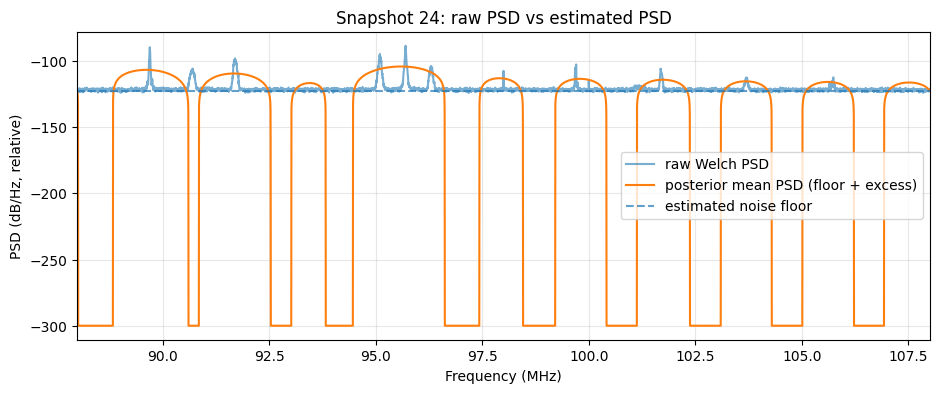

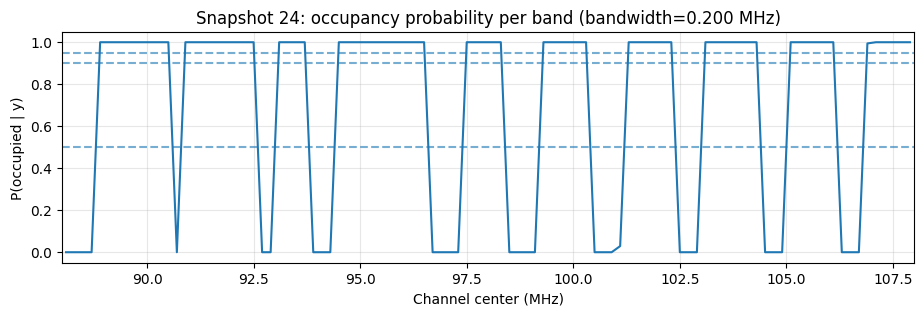

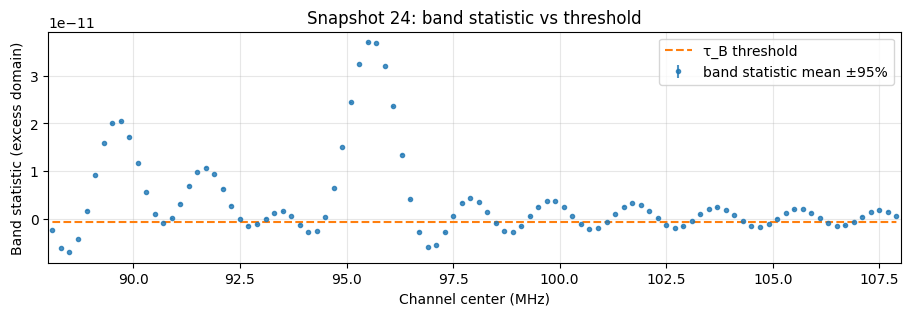

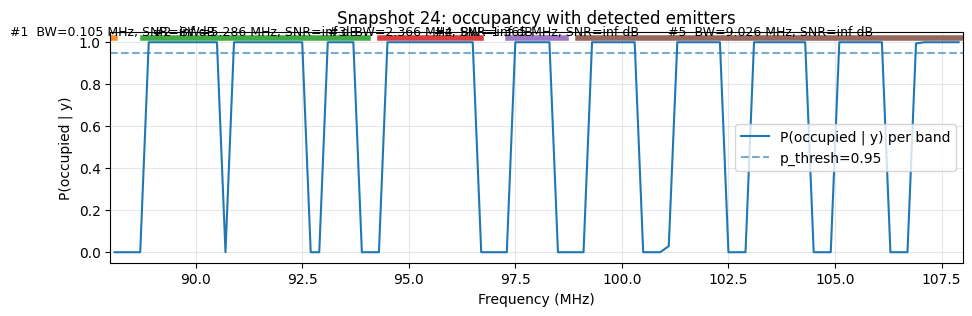

Snapshot 24: Detected emitters
  #1: 88.000–88.105 MHz  (BW=0.105 MHz)  peak=88.000  centroid=0.000  SNR=inf dB
  #2: 88.769–94.055 MHz  (BW=5.286 MHz)  peak=89.621  centroid=90.381  SNR=inf dB
  #3: 94.321–96.687 MHz  (BW=2.366 MHz)  peak=95.598  centroid=95.580  SNR=inf dB
  #4: 97.319–98.684 MHz  (BW=1.365 MHz)  peak=97.902  centroid=97.920  SNR=inf dB
  #5: 98.972–107.998 MHz  (BW=9.026 MHz)  peak=99.792  centroid=102.791  SNR=inf dB


In [6]:
t = 24
plot_snapshot_psd(out, t=t, show_uncertainty=False)
plot_band_occupancy(out, t=t)
plot_emitters_snapshot(out, t=t, p_thresh=0.95)


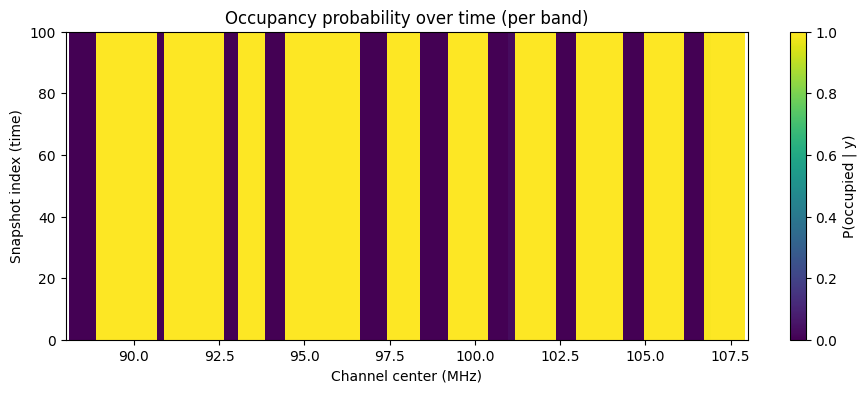

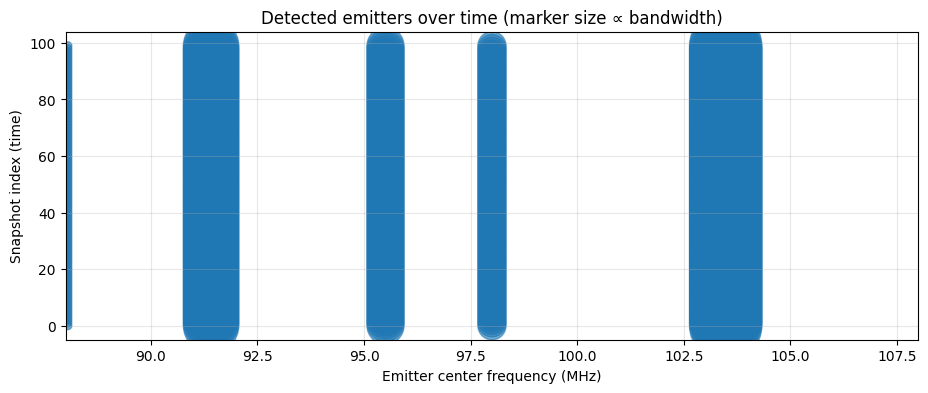

In [7]:
plot_occupancy_heatmap(out)
plot_bandwidth_over_time(out)


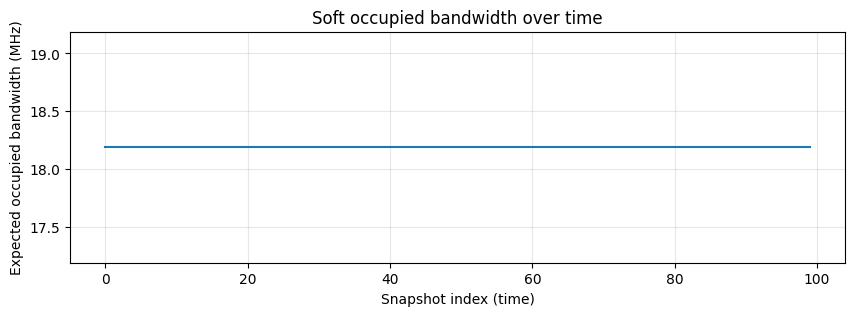

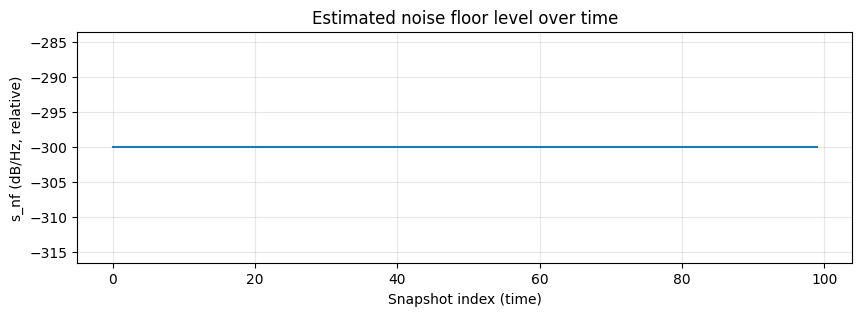

In [8]:
per = out["per_snapshot"]
expected_bw_mhz = np.array([p["expected_Bocc_hz"]/1e6 for p in per])
snf_db = np.array([10*np.log10(max(p["snf_used"], 1e-30)) for p in per])

plt.figure(figsize=(10,3))
plt.plot(expected_bw_mhz)
plt.xlabel("Snapshot index (time)")
plt.ylabel("Expected occupied bandwidth (MHz)")
plt.title("Soft occupied bandwidth over time")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,3))
plt.plot(snf_db)
plt.xlabel("Snapshot index (time)")
plt.ylabel("s_nf (dB/Hz, relative)")
plt.title("Estimated noise floor level over time")
plt.grid(True, alpha=0.3)
plt.show()
